# Slice Sampling

* example 1 : exponential distribution on [0,1]
* example 2 : general case

## 0. Import

In [1]:
using Plots
using LinearAlgebra
using Distributions
pyplot()

Plots.PyPlotBackend()

## 1. example 1 : Exponential Distribution on [0,1]

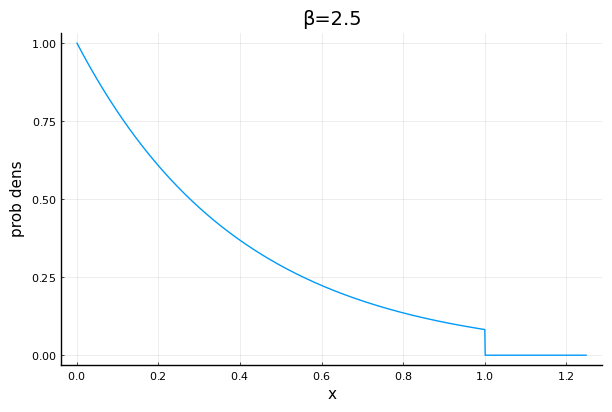

In [2]:
#pdf
β = 2.5
func1(x,β) = 0. ≤ x ≤ 1.0 ? exp(-β*x) : 0
f1(x) = func1(x, β)
fig1 = plot(0:0.001:1.25, f1, xlabel="x", ylabel="prob dens", title="β=$(β)", legend=false)
savefig(fig1, "figs-slice/fig1.png")

## 2. slice sampling for example 1

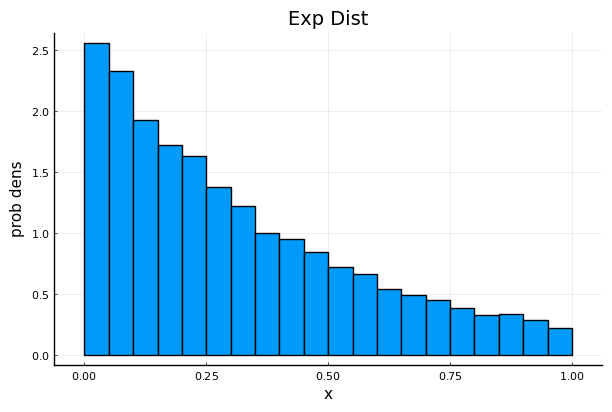

In [3]:
#区間を計算する
function calc_interval(x, β, l)
    if exp(-β) ≤ l
        x = -1/β*log(l) * rand()
    else
        x = rand()
    end
    return x
end

#slice sampling 
function my_slice_sampling1(x₀, n_iter, n_burnin, β, f)
    #初期値と保存用配列
    x = x₀
    xsamps = zeros(n_iter)
    lsamps = zeros(n_iter)
    xsamps[1] = x
    
    for k in 2:n_iter
        #uのサンプル
        l = f(x)*rand()
        lsamps[k] = l
        
        #xのサンプル
        x = calc_interval(x, β, l)
        xsamps[k] = x
    end
    return lsamps[n_burnin:end], xsamps[n_burnin:end]
end

#sample
n_samps = 10000
n_burnin = 1000
β = 2.5
lsamps1,xsamps1 = my_slice_sampling1(0.0, n_samps, n_burnin, β, f1) 

#show the result
fig2 = plot(xsamps1, st=:histogram, xlabel="x", ylabel="prob dens", normed=true, legend=false, title="Exp Dist")
savefig(fig2, "figs-slice/fig2.png")

## 3. animation for example 1

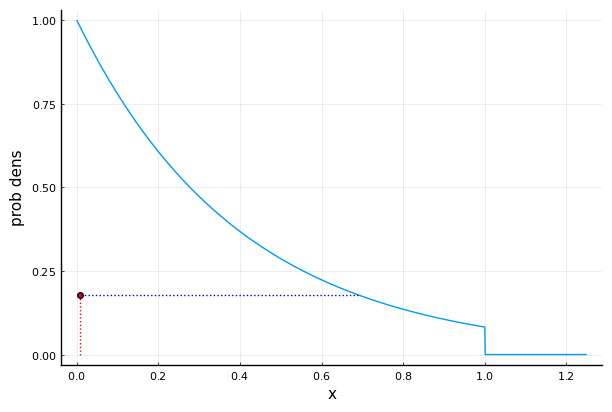

┌ Info: Saved animation to 
│   fn = /Users/kitanotomoya/Documents/julia/ML/figs-slice/anim1.gif
└ @ Plots /Users/kitanotomoya/.julia/packages/Plots/Di0Qb/src/animation.jl:114


Plots.AnimatedGif("/Users/kitanotomoya/Documents/julia/ML/figs-slice/anim1.gif")
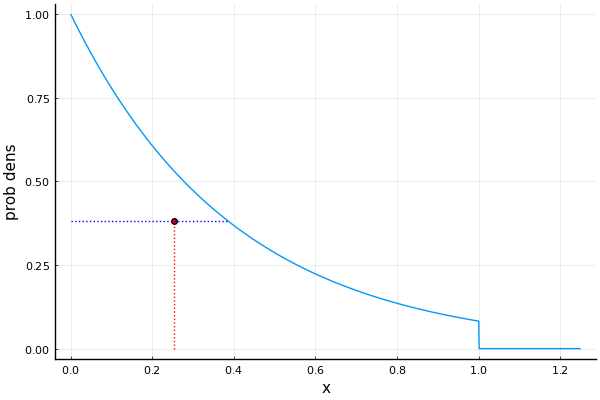

In [4]:
anim1 = @animate for i in 1:100
    x = xsamps1[i]
    l = lsamps1[i+1]
    plot(0:0.001:1.25, f1, xlabel="x", ylabel="prob dens", legend=false)
    plot!([x, x], [0, l], ls=:dot, color=:red)
    plot!([x], [l], st=:scatter, color=:red)
    if exp(-β) ≤ l
        R = -1/β*log(l)
    else
        R = 1
    end
    plot!([0,R], [l,l], ls=:dot, color=:blue)
end
gif(anim1, "figs-slice/anim1.gif", fps=5)

## 4. example 2 : general case

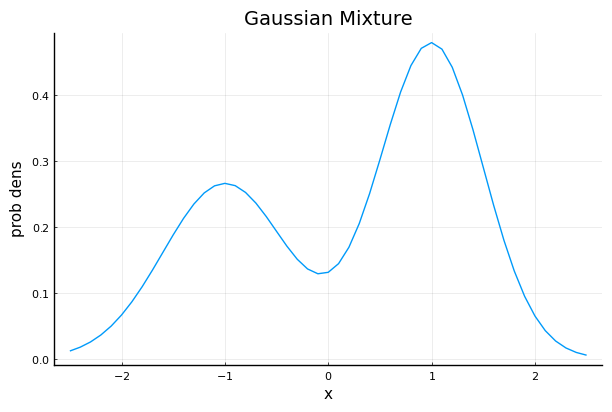

In [5]:
#Gaussian mixture
function f2(x)
    return 0.4*pdf(Normal(-1.0, 0.6),x) + 0.6*pdf(Normal(1.0, 0.5),x)
end

fig3 = plot(-2.5:0.1:2.5, f2, xlabel="x", ylabel="prob dens", title="Gaussian Mixture", legend=false)
savefig(fig3, "figs-slice/fig3.png")

## 5. slice sampling for example 2

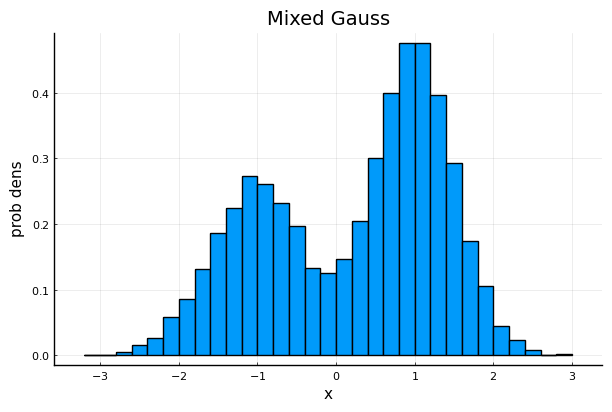

In [6]:
#update the interval
function update_end(e, w, l, f, nmax)
    for k in 1:nmax
        e = e + w #if e=L, then -w
        if f(e) ≤ l
            return e
            break
        end
    end
    return e
end

#stepping out
function stepping_out(x, w, l, f, nmax)
    u = rand()
    L = x - u*w
    R = L + w
    L = update_end(L, -w, l, f, nmax)
    R = update_end(R, w, l, f, nmax)
    return L, R
end

#shrinkage procedure
function shrinkage(x, L, R, l, f)
    Lnew = L
    Rnew = R
    xnew = Lnew+(Rnew-Lnew)*rand()
    
    while f(xnew) ≤ l
        if xnew < x
            Lnew = xnew
        else 
            Rnew = xnew
        end
        xnew = Lnew + (Rnew-Lnew)*rand()
    end
    return xnew, Lnew, Rnew
end

#slice sampling
function my_slice_sampling2(x₀, n_samps, n_burnin, w, nmax, f)
    #initialize
    xsamps = zeros(n_samps)
    lsamps = zeros(n_samps)
    Ls = zeros(n_samps)
    Rs = zeros(n_samps)
    xsamps[1] = x₀
    
    #sample
    x = x₀
    for k in 2:n_samps
        #slice level
        l = f(x)*rand()
        
        #calculate the interval
        L,R = stepping_out(x, w, l, f, nmax)
    
        #sample from the interval
        x, Lnew, Rnew = shrinkage(x, L, R, l, f)
        Ls[k] = Lnew
        Rs[k] = Rnew
        xsamps[k] = x
        lsamps[k] = l
    end
    return  lsamps[n_burnin:end], xsamps[n_burnin:end], Ls[n_burnin:end], Rs[n_burnin:end]
end

#sample
n_samps = 10000
n_burnin = 1000
w = 0.1
nmax = 100
lsamps2, xsamps2, Ls2, Rs2 = my_slice_sampling2(0.0, n_samps, n_burnin, w, nmax, f2)

#show the result
fig4 = plot(xsamps2, st=:histogram, xlabel="x", ylabel="prob dens", normed=true, legend=false, title="Mixed Gauss")
savefig(fig4, "figs-slice/fig4.png")

## 6. animation for example 2

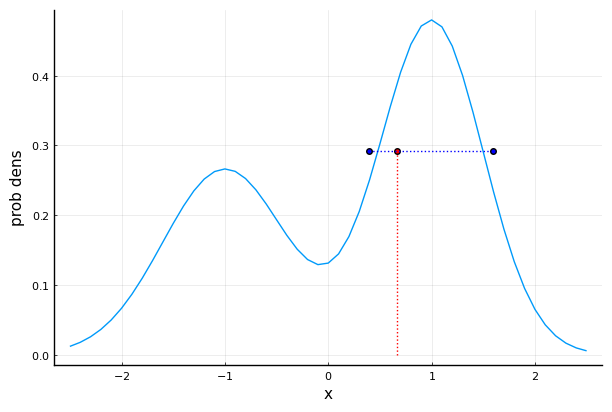

┌ Info: Saved animation to 
│   fn = /Users/kitanotomoya/Documents/julia/ML/figs-slice/anim2.gif
└ @ Plots /Users/kitanotomoya/.julia/packages/Plots/Di0Qb/src/animation.jl:114


Plots.AnimatedGif("/Users/kitanotomoya/Documents/julia/ML/figs-slice/anim2.gif")
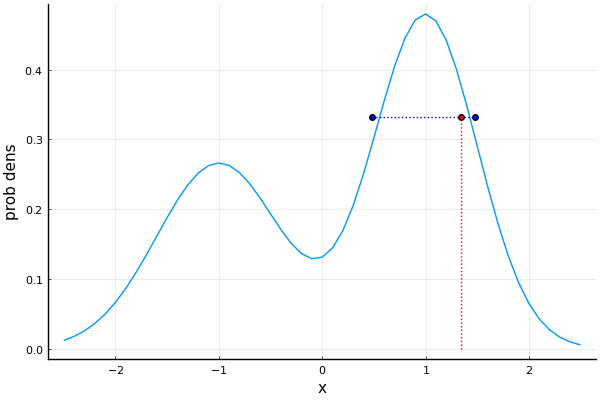

In [7]:
anim2 = @animate for i in 1:100
    x = xsamps2[i]
    l = lsamps2[i+1]
    L = Ls2[i+1]
    R = Rs2[i+1]
    plot(-2.5:0.1:2.5, f2, xlabel="x", ylabel="prob dens", legend=false, xlim=[-2.5, 2.5])
    plot!([x, x], [0, l], ls=:dot, color=:red)
    plot!([x], [l], st=:scatter, color=:red)
    plot!([L,R], [l,l], ls=:dot, color=:blue)
    plot!([L,R], [l,l], st=:scatter, color=:blue)
end
gif(anim2, "figs-slice/anim2.gif", fps=5)